`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
# ---- All Datasets used for analysis and dasgoclient searches ---- #

"""
/JetHT/Run2016B_ver1-Nano25Oct2019_ver1-v1/NANOAOD
/JetHT/Run2016B_ver2-Nano25Oct2019_ver2-v1/NANOAOD
/JetHT/Run2016C-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2016D-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2016E-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2016F-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2016G-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2016H-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2017B-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2017C-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2017D-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2017E-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2017F-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2018A-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2018B-Nano25Oct2019-v1/NANOAOD
/JetHT/Run2018C-Nano25Oct2019-v2/NANOAOD
/JetHT/Run2018D-Nano25Oct2019_ver2-v1/NANOAOD

/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/NANOAODSIM
/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/NANOAODSIM
"""

'\n/JetHT/Run2016B_ver1-Nano25Oct2019_ver1-v1/NANOAOD\n/JetHT/Run2016B_ver2-Nano25Oct2019_ver2-v1/NANOAOD\n/JetHT/Run2016C-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2016D-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2016E-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2016F-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2016G-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2016H-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2017B-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2017C-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2017D-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2017E-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2017F-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2018A-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2018B-Nano25Oct2019-v1/NANOAOD\n/JetHT/Run2018C-Nano25Oct2019-v2/NANOAOD\n/JetHT/Run2018D-Nano25Oct2019_ver2-v1/NANOAOD\n\n/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/NANOAODSIM\n/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/N

In [2]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from coffea import util
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd
from numpy.random import RandomState

In [3]:
xrootdstr1 = 'root://cmseos.fnal.gov//'
xrootdstr2 = 'root://cmsxrootd.fnal.gov//'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'

In [4]:
qcdfilename = 'QCD.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [5]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [6]:
jetdatafilename = 'JetHT_Data.txt'
with open(jetdatafilename) as f:
    jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines()[::3]] # Every third datafile
with open(jetdatafilename) as g:
    jetdatafiles2016 = [xrootdstr2 + s.strip() for s in g.readlines() if "/store/data/Run2016" in s]#[0::2]
with open(jetdatafilename) as h:
    jetdatafiles2017 = [xrootdstr2 + s.strip() for s in h.readlines() if "/store/data/Run2017" in s]
with open(jetdatafilename) as i:
    jetdatafiles2018 = [xrootdstr2 + s.strip() for s in i.readlines() if "/store/data/Run2018" in s]

In [7]:
#print(jetdatafiles[2]) # Test to see if correct files are collected

In [8]:
from columnservice.client import ColumnClient
cc = ColumnClient("coffea-dask.fnal.gov")
client = cc.get_dask()

In [9]:
btag0_bins = []
ix = 400
while ix <= 7000:
    btag0_bins.append(ix)
    if ix < 1000:
        ix += 100
    elif ix < 1200:
        ix += 200
    elif ix < 1500:
        ix += 300
    elif ix < 2000:
        ix += 500
    elif ix < 3000:
        ix += 1000
    else:
        ix += 4000
print(btag0_bins)

[400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 2000, 3000, 7000]


In [10]:
manual_bins = [400, 500, 600, 800, 1000, 1500, 2000, 3000, 7000]

In [11]:

"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, prng, htCut=950., minMSD=105., maxMSD=210., tau32Cut=0.65, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019, UseLookUpTables=False,
                lu = None):
        
        self.prng = prng
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        self.UseLookUpTables = UseLookUpTables
        self.lu = lu # Look Up Tables
        
        self.ttagcats = ["At","at", "0t", "1t", "2t"] #anti-tag+probe, anti-tag, 0, 1, 2 ttags
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 5000)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -5, 5)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -np.pi, np.pi)
        jety_axis = hist.Bin("jety", r"Jet $y$", 50, -3, 3)
        jetdy_axis = hist.Bin("jetdy", r"Jet $\Delta y$", 50, 0, 5)
        #jetp_axis = hist.Bin("jetp", r"Jet $p$ [GeV]", 100, 0, 10000)
        manual_axis = hist.Bin("jetp", r"Jet Momentum [GeV]", manual_bins)
        tagger_axis = hist.Bin("tagger", r"deepTag", 50, 0, 1)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -np.pi, np.pi)

        self._accumulator = processor.dict_accumulator({
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'jeteta':    hist.Hist("Counts", dataset_axis, cats_axis, jeteta_axis),
            'jetphi':    hist.Hist("Counts", dataset_axis, cats_axis, jetphi_axis),
            
            'probept':   hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'probep':    hist.Hist("Counts", dataset_axis, cats_axis, manual_axis),
            
            'jety':      hist.Hist("Counts", dataset_axis, cats_axis, jety_axis),
            'jetdy':     hist.Hist("Counts", dataset_axis, cats_axis, jetdy_axis),
            
            'deepTag_TvsQCD':   hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis, tagger_axis),
            'deepTagMD_TvsQCD': hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis, tagger_axis),
            
            'subjetmass':   hist.Hist("Counts", dataset_axis, cats_axis, subjetmass_axis),
            'subjetpt':     hist.Hist("Counts", dataset_axis, cats_axis, subjetpt_axis),
            'subjeteta':    hist.Hist("Counts", dataset_axis, cats_axis, subjeteta_axis),
            'subjetphi':    hist.Hist("Counts", dataset_axis, cats_axis, subjetphi_axis),
            
            'numerator':   hist.Hist("Counts", dataset_axis, cats_axis, manual_axis),
            'denominator': hist.Hist("Counts", dataset_axis, cats_axis, manual_axis),
            
            'cutflow': processor.defaultdict_accumulator(int),
            
        })

            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        #dataset = events.metadata['dataset']
        
        # ---- Define dataset ---- #
        dataset = df['dataset'] #coffea.processor.LazyDataFrame
        Dataset_info = df.available #list of available columns in LazyDataFrame object (Similar to 'Events->Show()' command in ROOT)
        
        # ---- Get triggers from Dataset_info ---- #
        triggers = [itrig for itrig in Dataset_info if 'HLT_PFHT' in itrig]
        AK8triggers = [itrig for itrig in Dataset_info if 'HLT_AK8PFHT' in itrig]

        # ---- Find numeric values in trigger strings ---- #
        triggers_cut1 = [sub.split('PFHT')[1] for sub in triggers] # Remove string characters from left of number
        triggers_cut2 = [sub.split('_')[0] for sub in triggers_cut1] # Remove string characters from right of number
        isTriggerValue = [val.isnumeric() for val in triggers_cut2] # Boolean -> if string is only a number
        triggers_cut2 = np.where(isTriggerValue, triggers_cut2, 0) # If string is not a number, replace with 0
        triggers_vals = [int(val) for val in triggers_cut2] # Convert string numbers to integers
        
        AK8triggers_cut1 = [sub.split('HT')[1] for sub in AK8triggers]
        AK8triggers_cut2 = [sub.split('_')[0] for sub in AK8triggers_cut1]
        isAK8TriggerValue = [val.isnumeric() for val in AK8triggers_cut2]
        AK8triggers_cut2 = np.where(isAK8TriggerValue, AK8triggers_cut2, 0)
        AK8triggers_vals = [int(val) for val in AK8triggers_cut2]
        
        # ---- Find Largest and Second Largest Value ---- #
        triggers_vals.sort(reverse = True)
        AK8triggers_vals.sort(reverse = True)
        
        triggers_vals1 = str(triggers_vals[0])
        triggers_vals2 = str(triggers_vals[1])
        AK8triggers_vals1 = str(AK8triggers_vals[0])
        AK8triggers_vals2 = str(AK8triggers_vals[1])
        
        # ---- Define strings for the selected triggers ---- #
        HLT_trig1_str = [itrig for itrig in triggers if (triggers_vals1) in itrig][0]
        HLT_trig2_str = [itrig for itrig in triggers if (triggers_vals2) in itrig][0]
        HLT_AK8_trig1_str = [itrig for itrig in AK8triggers if (AK8triggers_vals1) in itrig][0]
        HLT_AK8_trig2_str = [itrig for itrig in AK8triggers if (AK8triggers_vals2) in itrig][0]
        
        # ---- Define HLT triggers to be used ---- #
        HLT_trig1 = df[HLT_trig1_str]
        HLT_trig2 = df[HLT_trig2_str]
        HLT_AK8_trig1 = df[HLT_AK8_trig1_str]
        HLT_AK8_trig2 = df[HLT_AK8_trig2_str]
       
        
        # ---- Define AK8 Jets as FatJets ---- #
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            area=df['FatJet_area'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB'],
            btagCSVV2=df['FatJet_btagCSVV2'],
            deepTag_TvsQCD=df['FatJet_deepTag_TvsQCD'],
            deepTagMD_TvsQCD=df['FatJet_deepTagMD_TvsQCD'],
            subJetIdx1=df['FatJet_subJetIdx1'],
            subJetIdx2=df['FatJet_subJetIdx2']
            )
        
        # ---- Define AK4 jets as Jets ---- #
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt=df['Jet_pt'],
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass'],
            area=df['Jet_area']
            )
        # ---- Define SubJets ---- #
        SubJets = JaggedCandidateArray.candidatesfromcounts(
            df['nSubJet'],
            pt=df['SubJet_pt'],
            eta=df['SubJet_eta'],
            phi=df['SubJet_phi'],
            mass=df['SubJet_mass'],
            btagDeepB=df['SubJet_btagDeepB'],
            btagCSVV2=df['SubJet_btagCSVV2']
            )
        
        
        # ---- Get event weights from dataset ---- #
        if 'JetHT' in dataset: # If data is used...
            evtweights = np.ones(FatJets.size) # set all "data weights" to one
        else: # if Monte Carlo dataset is used...
            evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        
        # ---- Show all events ---- #
        output['cutflow']['all events'] += FatJets.size
        
        # ---- Apply Trigger(s) ---- #
        #FatJets = FatJets[HLT_AK8_trig1]
        #evtweights = evtweights[HLT_AK8_trig1]
        #Jets = Jets[HLT_AK8_trig1]
        #SubJets = SubJets[HLT_AK8_trig1]
    
        # ---- Jets that satisfy Jet ID ---- #
        jet_id = (FatJets.jetId > 0)
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        # ---- Apply Eta cut ---- #
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5) # eta cut here
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()
        
        # ---- Apply Rapidity cut ---- #
        #jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.p4.rapidity) < 2.5) # y cut here
        #FatJets = FatJets[ jetkincut_index ]
        #output['cutflow']['jet kin'] += jetkincut_index.any().sum()
        
        # ---- Ensure that FatJets are AK8 Jets ---- #
        #ak8Jets = FatJets.area > np.pi*0.8**2
        #FatJets = FatJets[ak8Jets]
        
        # ---- Find at least two AK8 Jets ---- #
        twoFatJetsKin = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJetsKin]
        evtweights = evtweights[twoFatJetsKin]
        Jets = Jets[twoFatJetsKin]
        SubJets = SubJets[twoFatJetsKin]
        output['cutflow']['two FatJets and jet kin'] += twoFatJetsKin.sum()
        
        # ---- Apply HT Cut ---- #
        #ak4Jets = Jets.area > np.pi*0.4**2
        #Jets = Jets[ak4Jets]
        hT = Jets.pt.sum()
        passhT = (hT > self.htCut)
        evtweights = evtweights[passhT]
        FatJets = FatJets[passhT]
        SubJets = SubJets[passhT]
        
        # ---- Randomly Select AK8 Jet as TTbar Candidate --- #
        highPhi = FatJets.phi[:,0] > FatJets.phi[:,1]
        highRandIndex = np.where(highPhi, 0, 1)
        #index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), prng.randint(2, size=len(FatJets)))
        index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), highRandIndex )
        jet0 = FatJets[index]
        jet1 = FatJets[1 - index]
        
        ttbarcands = jet0.cross(jet1) #FatJets[:,0:2].distincts()
        
        # ---- Look for at least 1 TTbar candidate pair and re-broadcast releveant arrays  ---- #
        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]
        SubJets = SubJets[oneTTbar]
         
        # ---- Apply Delta Phi Cut for Back to Back Topology ---- #
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut] 
        SubJets = SubJets[dPhiCut] 
        
        # ---- Identify subjets according to subjet ID ---- #
        #btag_i0 = (ttbarcands.i0.btagCSVV2 > self.bdisc)
        #btag_i1 = (ttbarcands.i1.btagCSVV2 > self.bdisc)
    
        hasSubjets0 = ((ttbarcands.i0.subJetIdx1 > -1) & (ttbarcands.i0.subJetIdx2 > -1))
        hasSubjets1 = ((ttbarcands.i1.subJetIdx1 > -1) & (ttbarcands.i1.subJetIdx2 > -1))
        GoodSubjets = ((hasSubjets0) & (hasSubjets1)).flatten()
   
        ttbarcands = ttbarcands[GoodSubjets] 
        SubJets = SubJets[GoodSubjets]
        evtweights = evtweights[GoodSubjets]
       
        SubJet01 = SubJets[ttbarcands.i0.subJetIdx1] # FatJet i0 with subjet 1
        SubJet02 = SubJets[ttbarcands.i0.subJetIdx2] # FatJet i0 with subjet 2
        SubJet11 = SubJets[ttbarcands.i1.subJetIdx1] # FatJet i1 with subjet 1
        SubJet12 = SubJets[ttbarcands.i1.subJetIdx2] # FatJet i1 with subjet 2
        
        # ---- Get Analysis Categories ---- # 
        # ---- They are (central, forward)   cross   (0b,1b,>=2b) ---- #
        cen = np.abs(ttbarcands.i0.p4.rapidity - ttbarcands.i1.p4.rapidity) < 1.0
        fwd = (~cen)
        tau32_i0 = np.where(ttbarcands.i0.tau2>0,ttbarcands.i0.tau3/ttbarcands.i0.tau2, 0 )
        tau32_i1 = np.where(ttbarcands.i1.tau2>0,ttbarcands.i1.tau3/ttbarcands.i1.tau2, 0 )
        taucut_i0 = tau32_i0 < self.tau32Cut
        taucut_i1 = tau32_i1 < self.tau32Cut
        mcut_i0 = (self.minMSD < ttbarcands.i0.msoftdrop) & (ttbarcands.i0.msoftdrop < self.maxMSD) 
        mcut_i1 = (self.minMSD < ttbarcands.i1.msoftdrop) & (ttbarcands.i1.msoftdrop < self.maxMSD) 

        ttag_i0 = (taucut_i0) & (mcut_i0)
        ttag_i1 = (taucut_i1) & (mcut_i1)
        antitag = (~taucut_i0) & (mcut_i0) #Probe will always be ttbarcands.i1
        
        ttag0 = (~ttag_i0) & (~ttag_i1)
        ttag1 = ttag_i0 ^ ttag_i1
        ttag2 = ttag_i0 & ttag_i1
        
        # ---- Pick FatJet that passes btag cut based on its subjet with the highest btag value ---- # 
        btag_i0 = ( np.maximum(SubJet01.btagCSVV2 , SubJet02.btagCSVV2) > self.bdisc )
        btag_i1 = ( np.maximum(SubJet11.btagCSVV2 , SubJet12.btagCSVV2) > self.bdisc )

        btag0 = (~btag_i0) & (~btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        antitag_probe = np.logical_and(antitag, ttag_i1) #Found an antitag and ttagged probe pair for mistag rate
        
        regs = [cen,fwd]
        btags = [btag0,btag1,btag2]
        ttags = [antitag_probe,antitag,ttag0,ttag1,ttag2]
        cats = [ (t&b&y).flatten() for t,b,y in itertools.product( ttags, btags, regs) ]
        labels_and_categories = dict(zip( self.anacats, cats ))
        
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        jetpt = ttbarcands.pt.flatten()
        jeteta = ttbarcands.eta.flatten()
        jetphi = ttbarcands.phi.flatten()
        jety = ttbarcands.p4.rapidity.flatten()
        jetdy = np.abs(ttbarcands.i0.p4.rapidity.flatten() - ttbarcands.i1.p4.rapidity.flatten())
        
        deepTag = ttbarcands.i1.deepTag_TvsQCD.flatten()
        deepTagMD = ttbarcands.i1.deepTagMD_TvsQCD.flatten()
      
        weights = evtweights.flatten()
        #weights[weights < 0] = 0
        
        # ---- Define the SumW2 for MC Datasets ---- #
        output['cutflow']['sumw'] += np.sum(weights)
        output['cutflow']['sumw2'] += np.sum(weights**2)
        
        # ---- Define Momentum p of probe jet as the Mistag Rate variable; M(p) ---- #
        # ---- Transverse Momentum pT can also be used instead; M(pT) ---- #
        pT = ttbarcands.i1.pt.flatten()
        eta = ttbarcands.i1.eta.flatten()
        pz = np.sinh(eta)*pT
        p = np.absolute(np.sqrt(pT**2 + pz**2))
        
        # ---- Define the Numerator and Denominator for Mistag Rate ---- #
        numerator = np.where(antitag_probe, p, -1) # If no antitag and tagged probe, move event to useless bin
        denominator = np.where(antitag, p, -1) # If no antitag, move event to useless bin
        
        df = pd.DataFrame({"momentum":p}) # Used for finding values in LookUp Tables
        
        for ilabel,icat in labels_and_categories.items():
            ### ------------------------------------ Mistag Scaling ------------------------------------ ###
            if self.UseLookUpTables == True:
                file_df = self.lu[dataset]['at' + str(ilabel[2:])] # get mistag (lookup) filename for 'at'
                bin_widths = file_df['p'].values # collect bins as written in .csv file
                mtr = file_df['M(p)'].values # collect mistag rate as function of p as written in file
                wgts = mtr # Define weights based on mistag rates
                
                BinKeys = np.arange(bin_widths.size) # Use as label for BinNumber column in the new dataframe
                
                #Bins = pd.interval_range(start=0, periods=100, freq=100, closed='left') # Recreate the momentum bins from file_df as something readable for pd.cut()
                Bins = np.array(manual_bins)
                
                df['BinWidth'] = pd.cut(p, bins=Bins) # new dataframe column
                df['BinNumber'] = pd.cut(p, bins=Bins, labels=BinKeys)
                #df['BinNumber'] = pd.cut(p, bins=Bins).map(dict(zip(Bins,BinKeys))) # Use if Bins is defined by pd.interval_range
                
                BinNumber = df['BinNumber'].values # Collect the Bin Numbers into a numpy array
                BinNumber = BinNumber.astype('int64') # Insures the bin numbers are integers
            
                WeightMatching = wgts[BinNumber] # Match 'wgts' with corresponding p bin using the bin number
                Weights = weights*WeightMatching # Include 'wgts' with the previously defined 'weights'
            else:
                Weights = weights # No mistag rates, no change to weights
            ###---------------------------------------------------------------------------------------------###
            output['cutflow'][ilabel] += np.sum(icat)
          
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=Weights[icat])
            output['jetpt'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=jetpt[icat],
                                weight=Weights[icat])
            output['probept'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=pT[icat],
                                weight=Weights[icat])
            output['probep'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=p[icat],
                                weight=Weights[icat])
            output['jeteta'].fill(dataset=dataset, anacat=ilabel, 
                                jeteta=jeteta[icat],
                                weight=Weights[icat])
            output['jetphi'].fill(dataset=dataset, anacat=ilabel, 
                                jetphi=jetphi[icat],
                                weight=Weights[icat])
            output['jety'].fill(dataset=dataset, anacat=ilabel, 
                                jety=jety[icat],
                                weight=Weights[icat])
            output['jetdy'].fill(dataset=dataset, anacat=ilabel, 
                                jetdy=jetdy[icat],
                                weight=Weights[icat])
            output['numerator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=numerator[icat],
                                weight=Weights[icat])
            output['denominator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=denominator[icat],
                                weight=Weights[icat])
            output['deepTag_TvsQCD'].fill(dataset=dataset, anacat=ilabel,
                                          jetpt=pT[icat],
                                          tagger=deepTag[icat],
                                          weight=Weights[icat])
            output['deepTagMD_TvsQCD'].fill(dataset=dataset, anacat=ilabel,
                                            jetpt=pT[icat],
                                            tagger=deepTagMD[icat],
                                            weight=Weights[icat])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [12]:
filesets = {
    #'TTbar':ttbarfiles,
    #'QCD':qcdfiles
    #'JetHT':jetdatafiles,
    'JetHT2016_Data':jetdatafiles2016
    #'JetHT2017_Data':jetdatafiles2017,
    #'JetHT2018_Data':jetdatafiles2018
}

In [13]:
tstart = time.time()

outputs_unweighted = {}

seed = 1234567890
prng = RandomState(seed)
Chunk = [100000, 400] # [chunksize, maxchunks]

for name,files in filesets.items(): 
    

    print(name)
    output = processor.run_uproot_job({name:files},
                                      treename='Events',
                                      processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                          prng=prng),
                                      executor=processor.dask_executor,
                                      #executor=processor.iterative_executor,
                                      #executor=processor.futures_executor,
                                      executor_args={
                                          'client': client, 
                                          'nano':False, 
                                          'flatten':True, 
                                          'skipbadfiles':False,
                                          'workers': 2},
                                      #chunksize=Chunk[0], maxchunks=Chunk[1]
                                     )

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    print(output)
    util.save(output, 'TTbarResCoffea_' + name + '_unweighted_output.coffea')

JetHT2016_Data
['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']
{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7f4d4c234b50>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7f4d496f9290>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7f4d496f92d0>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7f4d496f9150>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7f4d49794550>, 'probept': <Hist (dataset,anacat,jetpt) instance at 0x7f4d4b0b4110>, 'probep': <Hist (dataset,anacat,jetp) instance at 0x7f4d49716d10>, 'jety': <Hist (dataset,anacat,jety) instance at 0x7f4d49716f50>, 'jetdy': <Hist (dataset,anacat,jetdy) instance at 0x7f4d49716cd0>, 'deepTag_TvsQCD': <Hist (dataset,a

In [14]:
print('Elapsed time = ', elapsed, ' sec.')
print('Elapsed time = ', elapsed/60., ' min.')
print('Elapsed time = ', elapsed/3600., ' hrs.') 

Elapsed time =  2890.823765516281  sec.
Elapsed time =  48.18039609193802  min.
Elapsed time =  0.8030066015323003  hrs.


In [15]:
for name,output in outputs_unweighted.items(): 
    print("-------Unweighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------Unweighted JetHT2016_Data--------
          all events :    625516390
              jet id :    435342998
             jet kin :    122646585
two FatJets and jet kin :     53528747
     >= one oneTTbar :     42565375
          dPhi > 2.1 :     22131274
                sumw :     21404347
               sumw2 :     21404347
             At0bcen :        39347
             At0bfwd :        38756
             At1bcen :        21345
             At1bfwd :        21131
             At2bcen :         4064
             At2bfwd :         3439
             at0bcen :      1003761
             at0bfwd :      1024694
             at1bcen :       437583
             at1bfwd :       446771
             at2bcen :        51150
             at2bfwd :        50610
             0t0bcen :      6819944
             0t0bfwd :      7105628
             0t1bcen :      2537180
             0t1bfwd :      2649679
             0t2bcen :       252963
             0t2bfwd :       259320
             1t0bcen

In [16]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [17]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [18]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

In [19]:
import os

In [20]:
maindirectory = os.getcwd() # changes accordingly

/work/TTbarAllHadUproot/MistagPlots/
JetHT2016_Data
at0bcen
<Hist (dataset,anacat,jetp) instance at 0x7f4d496d9ed0>
<Hist (jetp) instance at 0x7f4d33675110>
<Hist (jetp) instance at 0x7f4d33675290>
JetHT2016_Data
at0bfwd
<Hist (dataset,anacat,jetp) instance at 0x7f4d496d9ed0>
<Hist (jetp) instance at 0x7f4d33355fd0>
<Hist (jetp) instance at 0x7f4d3336f150>
JetHT2016_Data
at1bcen
<Hist (dataset,anacat,jetp) instance at 0x7f4d496d9ed0>
<Hist (jetp) instance at 0x7f4d3333a7d0>
<Hist (jetp) instance at 0x7f4d3333a910>
JetHT2016_Data
at1bfwd
<Hist (dataset,anacat,jetp) instance at 0x7f4d496d9ed0>
<Hist (jetp) instance at 0x7f4d332fcf50>
<Hist (jetp) instance at 0x7f4d332870d0>
JetHT2016_Data
at2bcen
<Hist (dataset,anacat,jetp) instance at 0x7f4d496d9ed0>
<Hist (jetp) instance at 0x7f4d3324bc50>
<Hist (jetp) instance at 0x7f4d3324bd90>
JetHT2016_Data
at2bfwd
<Hist (dataset,anacat,jetp) instance at 0x7f4d496d9ed0>
<Hist (jetp) instance at 0x7f4d3321c990>
<Hist (jetp) instance at 0x7f4d3321cad

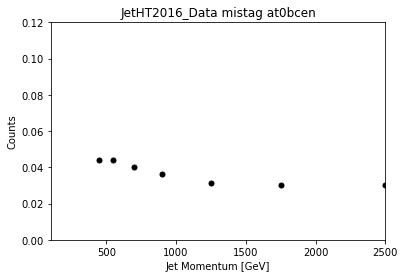

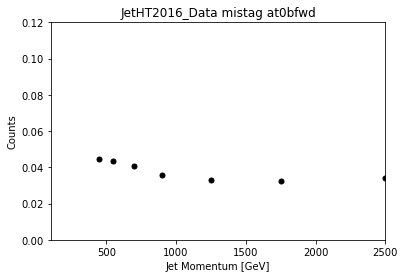

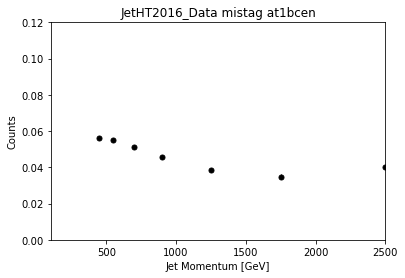

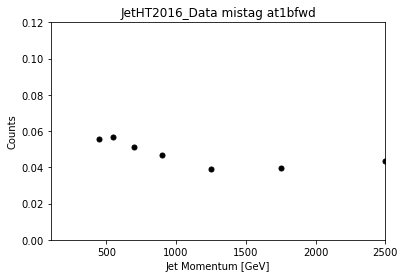

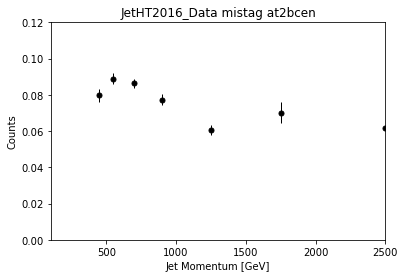

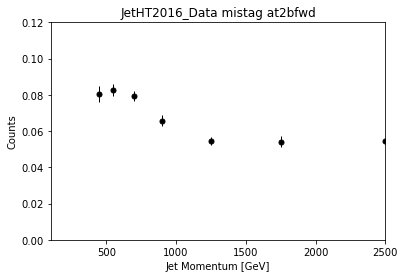

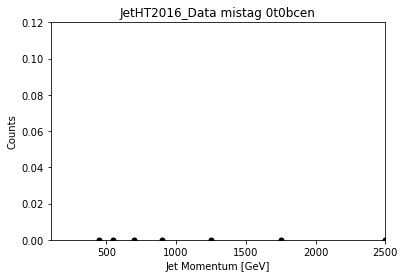

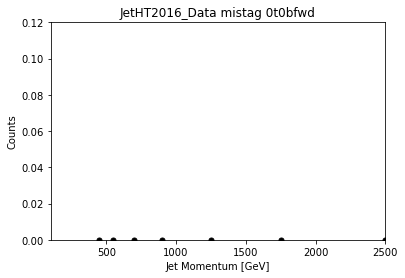

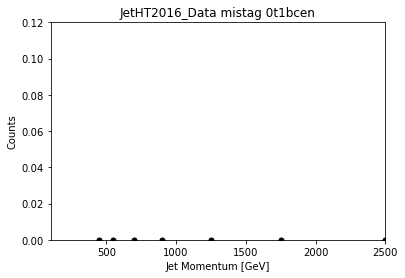

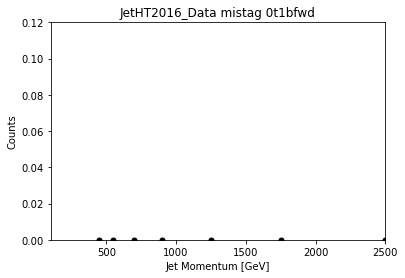

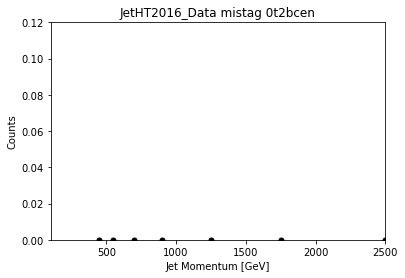

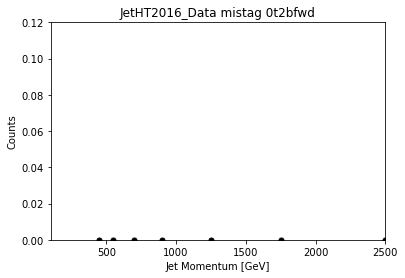

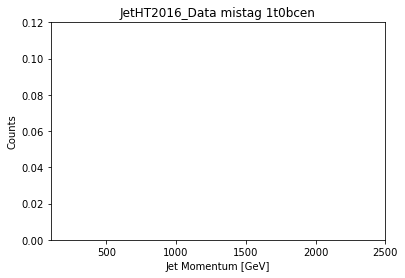

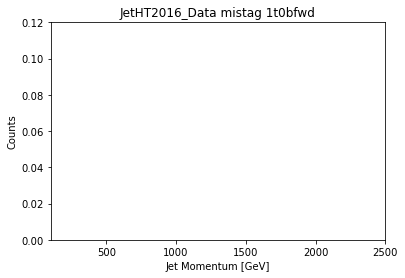

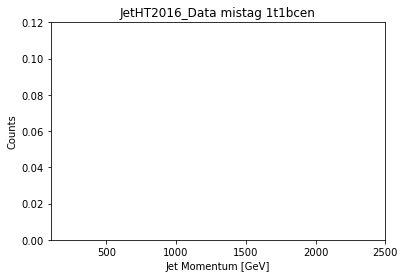

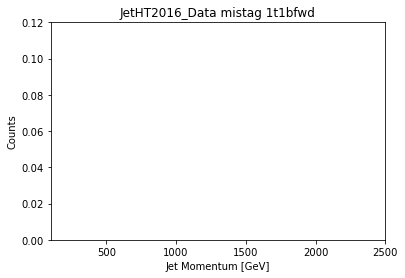

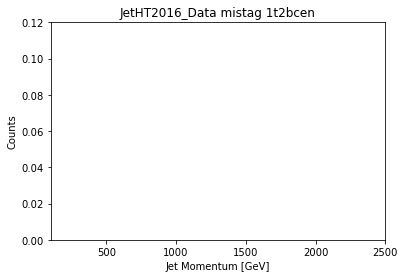

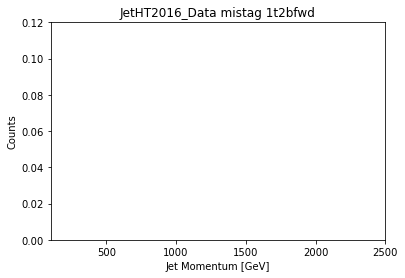

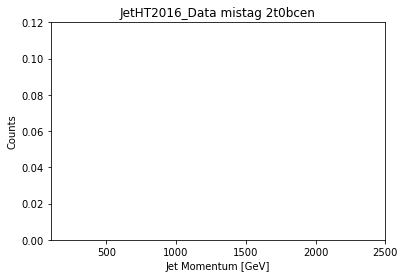

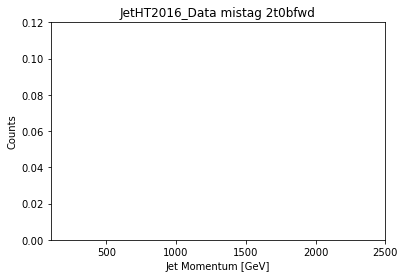

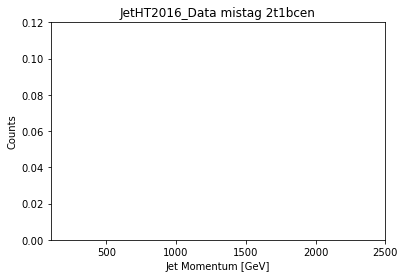

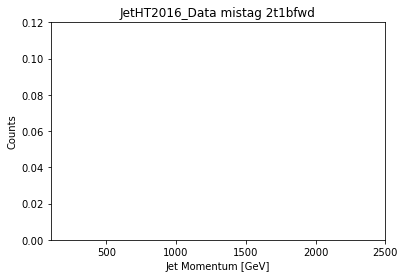

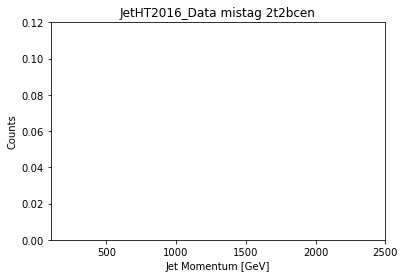

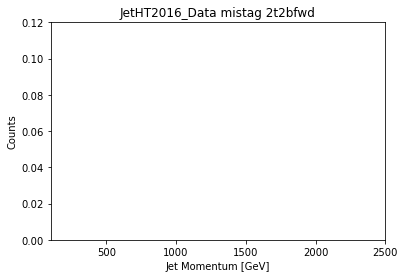

In [21]:
""" ---------------- CREATES MISTAG PLOTS ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #

SaveDirectory = maindirectory + '/MistagPlots/'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times

# Function sqrt(x)
def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2

print(SaveDirectory)
for iset in filesets:
    for icat in list_of_cats:
        print(iset)
        print(icat)
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'png'
        print(outputs_unweighted[iset]['numerator'])
        Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat', icat).integrate('dataset', iset)
        Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat', icat).integrate('dataset', iset)
        print(Numerator)
        print(Denominator)
        mistag = hist.plotratio(num = Numerator, denom = Denominator,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        plt.title(title)
        plt.ylim(bottom = 0, top = 0.12)
        plt.xlim(left = 100, right = 2500)
        #plt.xticks(np.array([0, 500, 600, 700]))
        #mistag.set_xscale('function', functions=(forward, inverse))
        #mistag.set_xscale('log')
        
        #plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        #print(filename + ' saved')


In [22]:
Nevts2016 = 625516390. # from dasgoclient
Nevts2016_totalchunks = Nevts2016 / Chunk[0]
Nevts2016_sf = Nevts2016_totalchunks / Chunk[1]

Nevts2017 = 410461585. # from dasgoclient
Nevts2017_totalchunks = Nevts2017 / Chunk[0]
Nevts2017_sf = Nevts2017_totalchunks / Chunk[1]

Nevts2018 = 676328827. # from dasgoclient
Nevts2018_totalchunks = Nevts2018 / Chunk[0]
Nevts2018_sf = Nevts2018_totalchunks / Chunk[1]

Nevts = Nevts2016 + Nevts2017 + Nevts2018
Nevts_totalchunks = Nevts / Chunk[0]
Nevts_sf = Nevts_totalchunks / Chunk[1]

print(Nevts2016_sf)
print(Nevts2017_sf)
print(Nevts2018_sf)
print(Nevts_sf)

15.637909749999999
10.261539625000001
16.908220675
42.80767005


In [23]:
""" ---------------- Luminosities, Cross Sections, Scale-Factors ---------------- """ 
Lum2016 = 35920. # pb^-1 from https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable
Lum2017 = 41530.
Lum2018 = 59740.
Lum     = 137190.

ttbar_BR = 0.457 # 0.442 from PDG 2018
ttbar_xs = 831.76 * ttbar_BR  #pb
ttbar2016_sf = ttbar_xs*Lum2016/142155064.
ttbar2017_sf = ttbar_xs*Lum2017/142155064.
ttbar2018_sf = ttbar_xs*Lum2018/142155064.
ttbar_sf = ttbar_xs*Lum/142155064.
print(ttbar2016_sf)
print(ttbar2017_sf)
print(ttbar2018_sf)
print(ttbar_sf)

qcd_xs = 1370000000.0 #pb From https://cms-gen-dev.cern.ch/xsdb
#qcd_sf = qcd_xs*Lum/18455107.

0.09604797740022826
0.11104878901535299
0.15974126308156003
0.3668380294971412


In [24]:
""" ---------------- CREATE LOOK UP TABLE .CSV FILES ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #
from collections import defaultdict

runLUTS = True 

def multi_dict(K, type): # definition from https://www.geeksforgeeks.org/python-creating-multidimensional-dictionary/
    if K == 1: 
        return defaultdict(type) 
    else: 
        return defaultdict(lambda: multi_dict(K-1, type))
    
luts = {}
luts = multi_dict(2, str)

if runLUTS : 

    SaveDirectory = maindirectory + '/LookupTables/'
    DoesDirectoryExist(SaveDirectory)

    for iset in filesets:
        if iset != 'TTbar' or iset != 'QCD': # if JetHT filesets are found...
            print('\t\tfileset: ' + iset + '\n*****************************************************\n')
            for icat in list_of_cats:
                title = iset + ' mistag ' + icat
                filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'
                
                # ---- Info from TTbar ---- #
                #Numerator_tt = outputs_unweighted['TTbar']['numerator'].integrate('anacat',icat).integrate('dataset','TTbar')
                #Denominator_tt = outputs_unweighted['TTbar']['denominator'].integrate('anacat',icat).integrate('dataset','TTbar')
                #N_vals_tt = np.zeros( np.size(Numerator_tt.values()[()]) ) #Numerator_tt.values()[()]
                #D_vals_tt = np.zeros( np.size(Denominator_tt.values()[()]) ) #Denominator_tt.values()[()]
                
                # ---- Info from JetHT datasets ---- #
                Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat',icat).integrate('dataset',iset)
                Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat',icat).integrate('dataset',iset)
                N_vals = Numerator.values()[()]
                D_vals = Denominator.values()[()]
                
                # ---- Properly scale chunks of data and ttbar MC according to year of dataset used---- #
                if '2016' in iset:
                    N_vals *= Nevts2016_sf 
                    D_vals *= Nevts2016_sf
                    #N_vals_tt *= ttbar2016_sf
                    #D_vals_tt *= ttbar2016_sf
                elif '2017' in iset:
                    N_vals *= Nevts2017_sf 
                    D_vals *= Nevts2017_sf
                    #N_vals_tt *= ttbar2017_sf
                    #D_vals_tt *= ttbar2017_sf
                elif '2018' in iset:
                    N_vals *= Nevts2018_sf 
                    D_vals *= Nevts2018_sf
                    #N_vals_tt *= ttbar2018_sf
                    #D_vals_tt *= ttbar2018_sf
                else:
                    N_vals *= Nevts_sf 
                    D_vals *= Nevts_sf
                    #N_vals_tt *= ttbar_sf
                    #D_vals_tt *= ttbar_sf
                
                # ---- Subtract ttbar MC probe momenta from datasets' ---- #
                N_vals_diff = N_vals #np.abs(N_vals-N_vals_tt)
                D_vals_diff = D_vals #np.abs(D_vals-D_vals_tt)

                print(N_vals_diff)
                print(D_vals_diff)
                print()

                # ---- Define Mistag values ---- #
                mistag_vals = np.where(D_vals_diff > 0, N_vals_diff/D_vals_diff, 0)

                p_vals = [] # Momentum values
                for iden in Numerator.identifiers('jetp'):
                    p_vals.append(iden)


                print('fileset:  ' + iset)
                print('category: ' + icat)
                print('________________________________________________\n')

                d = {'p': p_vals, 'M(p)': mistag_vals}

                #print("p vals = ", p_vals)
                print("d vals = ", d)
                print()
                df = pd.DataFrame(data=d)
                luts[iset][icat] = df

                with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                    print(df)
                print('\n')

                df.to_csv(SaveDirectory+filename) # use later to collect bins and weights for re-scaling
        else:
            for icat in list_of_cats:
                Numerator = outputs_unweighted[iset]['numerator'].integrate('anacat',icat).integrate('dataset',iset)
                Denominator = outputs_unweighted[iset]['denominator'].integrate('anacat',icat).integrate('dataset',iset)
                N_vals = Numerator.values()[()]
                D_vals = Denominator.values()[()]
                print(N_vals)
                print(D_vals)
                print()
                mistag_vals = np.where(D_vals > 0, N_vals/D_vals, 0)
                
                p_vals = [] # Momentum values
                for iden in Numerator.identifiers('jetp'):
                    p_vals.append(iden)
                print('fileset:  ' + iset)
                print('category: ' + icat)
                print('________________________________________________\n')
                d = {'p': p_vals, 'M(p)': mistag_vals}

                print("d vals = ", d)
                print()
                df = pd.DataFrame(data=d)
                luts[iset][icat] = df

                with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
                    print(df)
                print('\n')

                df.to_csv(SaveDirectory+filename) # use later to collect bins and weights for re-scaling
else :
    for iset in filesets:
        print('\t\tfileset: ' + iset + '\n*****************************************************\n')
        for icat in list_of_cats:
            title = iset + ' mistag ' + icat
            filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'
            luts[iset][icat] = pd.read_csv(filename)
print(luts)

		fileset: JetHT2016_Data
*****************************************************

[9.11690138e+04 1.49889365e+05 1.89906776e+05 8.58990383e+04
 7.25599012e+04 1.93753702e+04 6.38026718e+03 1.25103278e+02]
[2076730.05270975 3409017.41177075 4695829.72927875 2358040.4112025
 2295410.58265375  643484.34830275  212894.5033365     5316.889315  ]

fileset:  JetHT2016_Data
category: at0bcen
________________________________________________

d vals =  {'p': [<Interval ([400, 500)) instance at 0x7f4d328d6550>, <Interval ([500, 600)) instance at 0x7f4d328d61d0>, <Interval ([600, 800)) instance at 0x7f4d328d6310>, <Interval ([800, 1000)) instance at 0x7f4d328d6410>, <Interval ([1000, 1500)) instance at 0x7f4d328d6790>, <Interval ([1500, 2000)) instance at 0x7f4d328d62d0>, <Interval ([2000, 3000)) instance at 0x7f4d328d6450>, <Interval ([3000, 7000)) instance at 0x7f4d328d63d0>], 'M(p)': array([0.04390027, 0.04396849, 0.04044158, 0.03642815, 0.03161086,
       0.03011009, 0.02996915, 0.02352941])}



[ 7928.42024325 14543.2560675  20298.0068555   9758.055684
  7975.3339725   2392.60019175   625.51639       31.2758195 ]
[ 7928.42024325 14543.2560675  20298.0068555   9758.055684
  7975.3339725   2392.60019175   625.51639       31.2758195 ]

fileset:  JetHT2016_Data
category: 1t2bcen
________________________________________________

d vals =  {'p': [<Interval ([400, 500)) instance at 0x7f4d328d6550>, <Interval ([500, 600)) instance at 0x7f4d328d61d0>, <Interval ([600, 800)) instance at 0x7f4d328d6310>, <Interval ([800, 1000)) instance at 0x7f4d328d6410>, <Interval ([1000, 1500)) instance at 0x7f4d328d6790>, <Interval ([1500, 2000)) instance at 0x7f4d328d62d0>, <Interval ([2000, 3000)) instance at 0x7f4d328d6450>, <Interval ([3000, 7000)) instance at 0x7f4d328d63d0>], 'M(p)': array([1., 1., 1., 1., 1., 1., 1., 1.])}

              p  M(p)
0    [400, 500)   1.0
1    [500, 600)   1.0
2    [600, 800)   1.0
3   [800, 1000)   1.0
4  [1000, 1500)   1.0
5  [1500, 2000)   1.0
6  [2000, 3000)  

In [25]:
print("Events/s:", output['cutflow']['all events']/elapsed)

Events/s: 216379.98049607396


In [28]:
filesets = {
    #'TTbar':ttbarfiles,
    #'QCD':qcdfiles,
    #'JetHT':jetdatafiles,
    'JetHT2016_Data':jetdatafiles2016
    #'JetHT2017_Data':jetdatafiles2017,
    #'JetHT2018_Data':jetdatafiles2018
}

In [29]:
tstart = time.time()

outputs_weighted = {}
prng = RandomState(seed)
Chunk = [100000, 400] # [chunksize, maxchunks]

for name,files in filesets.items(): 
    

    print(name)
    output = processor.run_uproot_job({name:files},
                                      treename='Events',
                                      processor_instance=TTbarResProcessor(UseLookUpTables=True,
                                                                           lu=luts,
                                                                           prng=prng),
                                      executor=processor.dask_executor,
                                      #executor=processor.iterative_executor,
                                      #executor=processor.futures_executor,
                                      executor_args={
                                          'client': client, 
                                          'nano':False, 
                                          'flatten':True, 
                                          'skipbadfiles':False,
                                          'workers': 2},
                                      #chunksize=Chunk[0], maxchunks=Chunk[1]
                                     )

    elapsed = time.time() - tstart
    outputs_weighted[name] = output
    print(output)
    util.save(output, 'TTbarResCoffea_' + name + '_weighted_output.coffea')

JetHT2016_Data
['At0bcen', 'At0bfwd', 'At1bcen', 'At1bfwd', 'At2bcen', 'At2bfwd', 'at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']
{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7f4d496d9910>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7f4d327b5a50>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7f4d327b5a10>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7f4d327b59d0>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7f4d327b5150>, 'probept': <Hist (dataset,anacat,jetpt) instance at 0x7f4d327b5190>, 'probep': <Hist (dataset,anacat,jetp) instance at 0x7f4d327b5110>, 'jety': <Hist (dataset,anacat,jety) instance at 0x7f4d327b5090>, 'jetdy': <Hist (dataset,anacat,jetdy) instance at 0x7f4d327b50d0>, 'deepTag_TvsQCD': <Hist (dataset,a

In [30]:
for name,output in outputs_weighted.items(): 
    print("-------weighted " + name + "--------")
    for i,j in output['cutflow'].items():        
        print( '%20s : %12d' % (i,j) )

-------weighted JetHT2016_Data--------
          all events :    625516390
              jet id :    435342998
             jet kin :    122646585
two FatJets and jet kin :     53528747
     >= one oneTTbar :     42565375
          dPhi > 2.1 :     22131274
                sumw :     21404347
               sumw2 :     21404347
             At0bcen :        39347
             At0bfwd :        38756
             At1bcen :        21345
             At1bfwd :        21131
             At2bcen :         4064
             At2bfwd :         3439
             at0bcen :      1003761
             at0bfwd :      1024694
             at1bcen :       437583
             at1bfwd :       446771
             at2bcen :        51150
             at2bfwd :        50610
             0t0bcen :      6819944
             0t0bfwd :      7105628
             0t1bcen :      2537180
             0t1bfwd :      2649679
             0t2bcen :       252963
             0t2bfwd :       259320
             1t0bcen :